In [1]:
import json

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from sklearn.linear_model import LinearRegression


## Check the example data for any patters, to see if we can use it to generate more reasonable test instances

In [2]:
with open('../example_data/packages.json', 'r') as f:
    data_packages = json.load(f)

with open('../example_data/items.json', 'r') as f:
    data_item_price = json.load(f)

item_price_df = pd.DataFrame(data_item_price)
package_df = pd.DataFrame(data_packages)
package_df["package_id"] = package_df.index
package_item_df = package_df.explode("items")

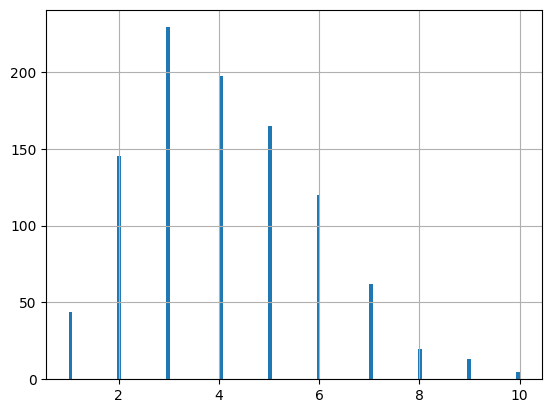

In [3]:
package_item_df.groupby("package_id")["items"].count().hist(bins=120)
# looks roughly like a neg binomial
data = package_item_df.groupby("package_id")["items"].count()

<Axes: >

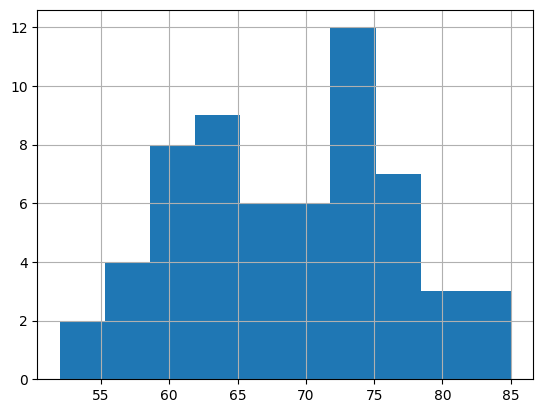

In [4]:
# each item is in roughly 55 to 85 packages
package_item_df.groupby("items").count()["package_id"].hist()

<Axes: >

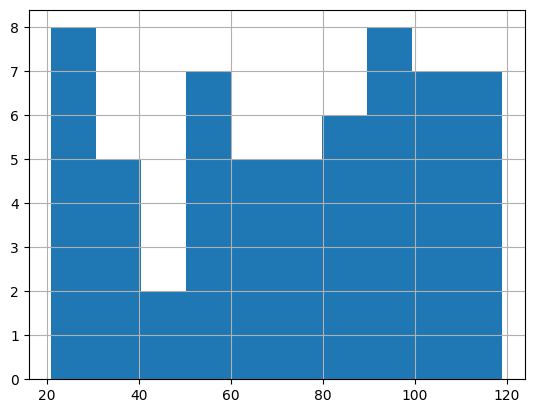

In [5]:
# prices seems to be roughly uniform distributed between 20 and 120
item_price_df["price"].hist()

array([[<Axes: title={'center': '0'}>]], dtype=object)

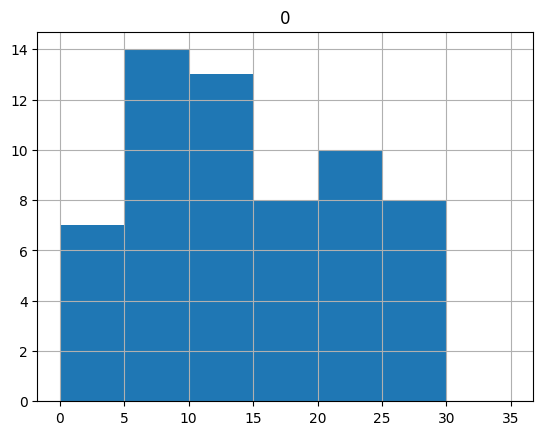

In [6]:
# make a linear regression to guess the individual item volumes
package_item_df["in_package"] = 1
X = package_item_df.pivot_table(index="package_id", columns="items", values="in_package",
                                fill_value=0).sort_index().to_numpy()
Y = package_df.sort_values("package_id")["total_volume"].to_numpy()
model = LinearRegression(fit_intercept=False)
model.fit(X, Y)

# let's assume that the item volumes are uniformly random between 0 and 30
pd.DataFrame(model.coef_).hist(bins=[0, 5, 10, 15, 20, 25, 30, 35])

In [7]:
# do a quick check whether some packages are not connected via items to others -> volumes could be estimated separately
G = nx.Graph()
for item_list in package_df['items']:
    G.add_nodes_from(item_list)

for item_list in package_df['items']:
    for i in range(len(item_list)):
        for j in range(i + 1, len(item_list)):
            G.add_edge(item_list[i], item_list[j])

In [8]:
connected_components = list(nx.connected_components(G))

for component in connected_components:
    print(component)
# everything is connected :)

{'A14', 'A28', 'A20', 'A35', 'A34', 'A3', 'A42', 'A19', 'A48', 'A29', 'A52', 'A13', 'A38', 'A26', 'A41', 'A31', 'A15', 'A58', 'A55', 'A8', 'A25', 'A53', 'A24', 'A37', 'A54', 'A21', 'A18', 'A12', 'A60', 'A9', 'A5', 'A27', 'A49', 'A40', 'A59', 'A46', 'A10', 'A45', 'A1', 'A30', 'A16', 'A51', 'A36', 'A50', 'A17', 'A6', 'A4', 'A47', 'A57', 'A23', 'A32', 'A22', 'A44', 'A56', 'A33', 'A43', 'A2', 'A39', 'A7', 'A11'}


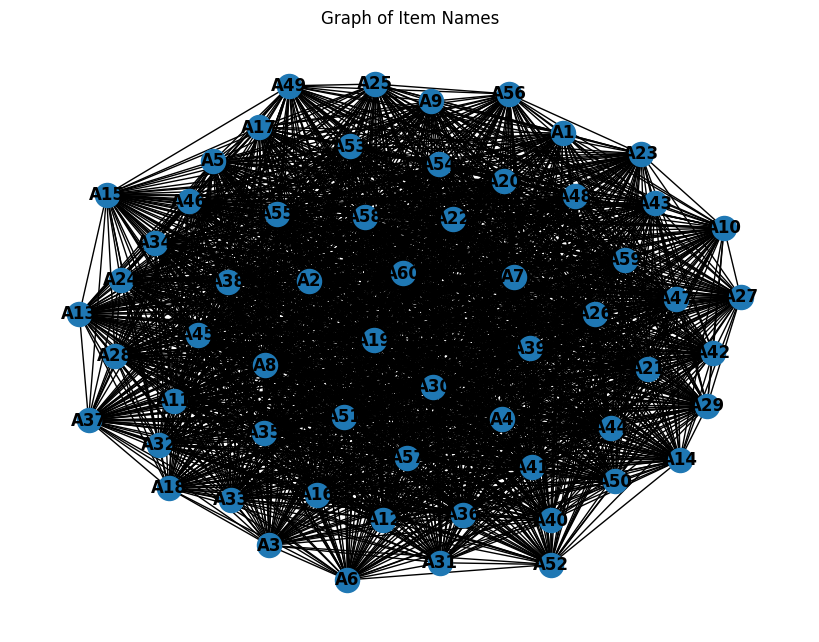

In [9]:
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, font_weight='bold')
plt.title('Graph of Item Names')
plt.show()